# FIUBA - CEIA - Visión por Computadora I
# TP1 — White Patch

Docente:    Ing. Maxim Dorogov

Alumnos:    - Cesar Octavio Mejia (a2221)
            - Carlos Alberto Rivas Araque (a2227)
            - Osvaldo Daniel Muñoz (a2222)


**Parte 1**: White Patch (naive y robusto pXX)  
**Parte 2**: Escala de grises, histogramas, comparación (chi-cuadrado / Bhattacharyya)

> Directorios:
> - `data/white_patch/`  (imágenes color para Parte 1)
> - `data/` con `img1_tp.png` y `img2_tp.png` (Parte 2)
> - `outputs/white_patch/` (resultados de whte patch)
> - `outputs/white_patch_analysis/` (resultados de robust percentile)

In [1]:
# Parte 1: Setup inicial, Librerías y rutas

from pathlib import Path
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tabulate import tabulate
import csv

# Configuracón general para plots
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

BASE = Path.cwd().parent              # .../TP1
DATA = BASE / "data"
DATA_WP = DATA / "white_patch"
OUT_WP = BASE / "outputs" / "white_patch"
OUT_WP.mkdir(parents=True, exist_ok=True)
OUT_ANALYSIS = BASE / "outputs" / "white_patch_analysis"
OUT_ANALYSIS.mkdir(parents=True, exist_ok=True)

print("BASE:", BASE.resolve())
print("DATA:", DATA.resolve())
print("DATA:", DATA_WP.resolve())
print("OUT_WP:", OUT_WP.resolve())
print("OUT_ANALYSIS", OUT_WP.resolve())

BASE: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1
DATA: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/data
DATA: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/data/white_patch
OUT_WP: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/outputs/white_patch
OUT_ANALYSIS /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/outputs/white_patch


In [2]:
# Funciones para análisis de defectos en las imágenes antes de aplicar White patch

# Parámetros por defecto (ajustables)
SAT_THR = 250               # umbral de saturación de canal (0..255)
SPEC_HIGH_P = 99.0          # percentil en intensidad para "muy brillante"
SPEC_NEUTRAL_STD = 0.05     # desvío intra-RGB para "casi gris" (0..1)
NOISE_DIFF_THR = 40         # diferencia vs mediana para marcar ruido (0..255)
MEDIAN_K = 3                # kernel de mediana para ruido (impar)
BLOCK_GRID = 8              # paso típico JPEG

def pct(mask: np.ndarray) -> float:
    return float(mask.mean() * 100.0)

def analyze_defects(img_bgr: np.ndarray,
                    sat_thr=SAT_THR,
                    spec_high_p=SPEC_HIGH_P,
                    spec_neutral_std=SPEC_NEUTRAL_STD,
                    noise_diff_thr=NOISE_DIFF_THR,
                    median_k=MEDIAN_K,
                    block_grid=BLOCK_GRID):
    H, W = img_bgr.shape[:2]
    # --- Saturados (al menos un canal alto) ---
    sat_mask = (img_bgr >= sat_thr).any(axis=2)

    # --- Especulares: muy brillantes + casi neutros ---
    imf = img_bgr.astype(np.float32) / 255.0
    intensity = imf.mean(axis=2)
    high_thr = np.percentile(intensity, spec_high_p)
    spec_mask_bright = intensity >= high_thr
    ch_std = imf.std(axis=2)
    spec_mask_neutral = ch_std <= spec_neutral_std
    spec_mask = spec_mask_bright & spec_mask_neutral

    # --- Ruido/hot: diferencia con mediana ---
    blur = cv.medianBlur(img_bgr, median_k)
    diff = cv.absdiff(img_bgr, blur)
    noisy_mask = (diff > noise_diff_thr).any(axis=2)

    # --- Blockiness JPEG (proxy sencillo normalizado) ---
    gray = cv.cvtColor(img_bgr, cv.COLOR_BGR2GRAY).astype(np.float32)
    gx = np.abs(np.diff(gray, axis=1)).mean()
    gy = np.abs(np.diff(gray, axis=0)).mean()
    edge_mean = (gx + gy) / 2.0 + 1e-6

    # saltos sobre líneas cada 8 px
    v_edges = np.abs(np.diff(gray[:, ::block_grid], axis=1)).mean()
    h_edges = np.abs(np.diff(gray[::block_grid, :], axis=0)).mean()
    blockiness_index = float((v_edges + h_edges) / (2.0 * edge_mean))

    # Sugerencia de percentil robusto (heurística)
    sat_p = pct(sat_mask)
    spec_p = pct(spec_mask)
    noise_p = pct(noisy_mask)

    if sat_p > 1.0 or spec_p > 0.5:      # mucha saturación/reflejos
        suggested_p = 95
    elif sat_p > 0.1 or spec_p > 0.1:    # moderado
        suggested_p = 97
    else:
        suggested_p = 99                 # imagen “sana”, ir alto

    metrics = {
        "h": H, "w": W,
        "sat_pct": round(sat_p, 4),
        "spec_pct": round(spec_p, 4),
        "noise_pct": round(noise_p, 4),
        "blockiness_idx": round(blockiness_index, 4),
        "suggested_percentile": suggested_p
    }

    masks = {
        "sat": sat_mask,
        "spec": spec_mask,
        "noise": noisy_mask
    }
    return metrics, masks

def save_masks_and_overlay(img_bgr: np.ndarray, masks: dict, out_dir: Path, stem: str):
    out_dir.mkdir(parents=True, exist_ok=True)

    # Guardar máscaras binarias
    for k, m in masks.items():
        cv.imwrite(str(out_dir / f"{stem}_mask_{k}.png"), (m.astype(np.uint8) * 255))

    # Acumular colores en uint16 para evitar overflow/casting
    accum = np.zeros_like(img_bgr, dtype=np.uint16)

    if "spec" in masks:
        accum[masks["spec"]] += np.array([0, 0, 255], dtype=np.uint16)   # rojo
    if "sat" in masks:
        accum[masks["sat"]]  += np.array([255, 0, 0], dtype=np.uint16)   # azul en BGR → (255,0,0)
    if "noise" in masks:
        accum[masks["noise"]] += np.array([0, 255, 255], dtype=np.uint16) # amarillo

    # Limitar a 0..255 y castear a uint8
    color = np.clip(accum, 0, 255).astype(np.uint8)

    # Overlay de los defectos sobre la imagen original
    overlay = cv.addWeighted(img_bgr, 0.7, color, 0.3, 0)
    cv.imwrite(str(out_dir / f"{stem}_overlay.png"), overlay)

def print_table(rows, cols, title=None, colalign=None):
    # formateo amable para % y floats
    def fmt(c, v):
        if c in {"sat_pct","spec_pct","noise_pct"} and v != "":
            return f"{float(v):.3f}%"
        if c == "blockiness_idx" and v != "":
            return f"{float(v):.3f}"
        return v

    data = [[fmt(c, r.get(c, "")) for c in cols] for r in rows]

    if colalign is None:
        # Inferir: 'file' y 'run_type' a la IZQ; números a la DER; el resto centrado si querés
        left_cols   = {"file", "run_type"}
        numeric_cols= {"w","h","sat_pct","spec_pct","noise_pct","blockiness_idx","suggested_percentile","used_percentile"}
        colalign = []
        for c in cols:
            if c in left_cols:
                colalign.append("left")
            elif c in numeric_cols:
                colalign.append("right")
            else:
                colalign.append("center")

    if title: print("\n" + title)
    print(tabulate(
        data,
        headers=cols,
        tablefmt="fancy_grid",
        colalign=tuple(colalign),  # ← alineación por columna
        stralign=None,             # deja que colalign mande
        numalign=None
    ))

In [3]:
# Utilidades y White Patch

# Castear a float32 y normaliza a rango [0,1]
def to_float01(img_bgr):
    return img_bgr.astype(np.float32) / 255.0

# Castear a uint8 desde float32 en rango [0,1], para evitar overflow
def to_uint8(img_float):
    img = np.clip(img_float * 255.0, 0, 255)
    return img.astype(np.uint8)

# White Patch: balance de blancos basado en el pixel más brillante
def white_patch(img_bgr, robust_percentile=None):
    """
    img_bgr: uint8 BGR
    robust_percentile: None (usa max) o p.ej. 99 para usar p99 por canal
    """
    img = to_float01(img_bgr)
    flat = img.reshape(-1, 3)
    if robust_percentile is None:
        anchors = flat.max(axis=0)  # B,G,R
    else:
        anchors = np.percentile(flat, robust_percentile, axis=0)
    anchors = np.maximum(anchors, 1e-6)
    gains = 1.0 / anchors
    corrected = img * gains
    corrected = np.clip(corrected, 0.0, 1.0)
    return to_uint8(corrected)

# Mostrar dos imágenes BGR lado a lado usando matplotlib (convierte a RGB)
def show_side_by_side_bgr(bgr_a, bgr_b, title_a="Original", title_b="Procesada"):
    rgb_a = cv.cvtColor(bgr_a, cv.COLOR_BGR2RGB)
    rgb_b = cv.cvtColor(bgr_b, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(rgb_a); plt.title(title_a); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(rgb_b); plt.title(title_b); plt.axis('off')
    plt.tight_layout(); plt.show()


Imágenes encontradas: 8


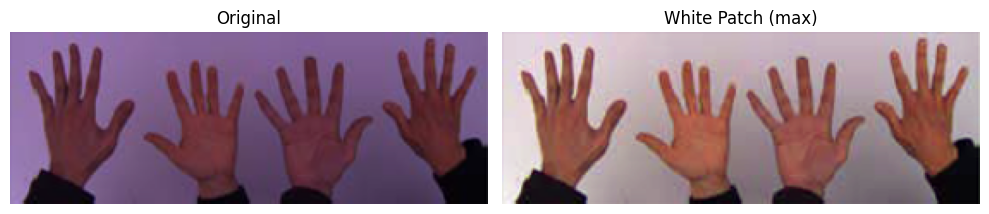

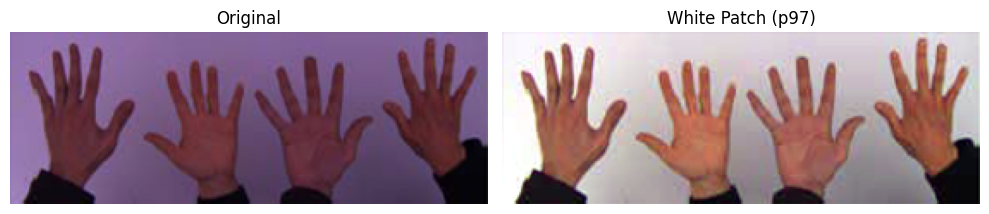

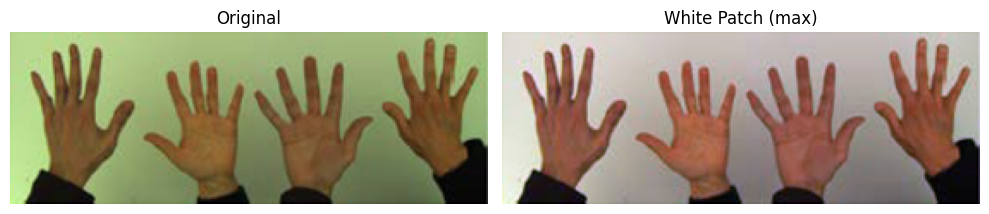

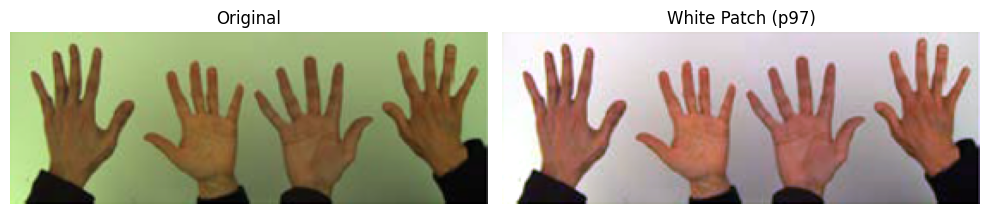

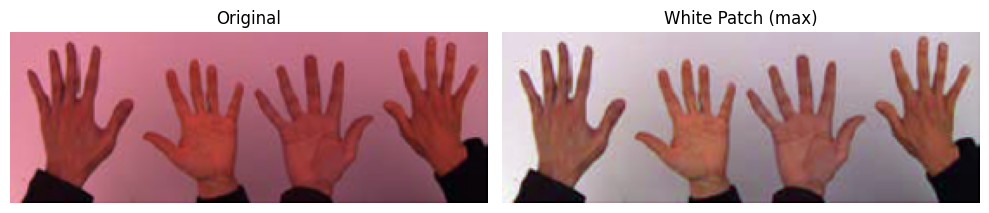

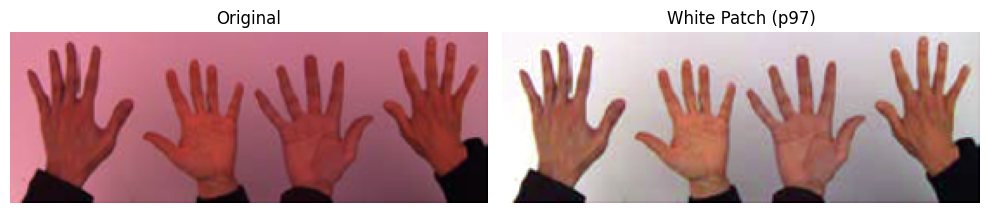

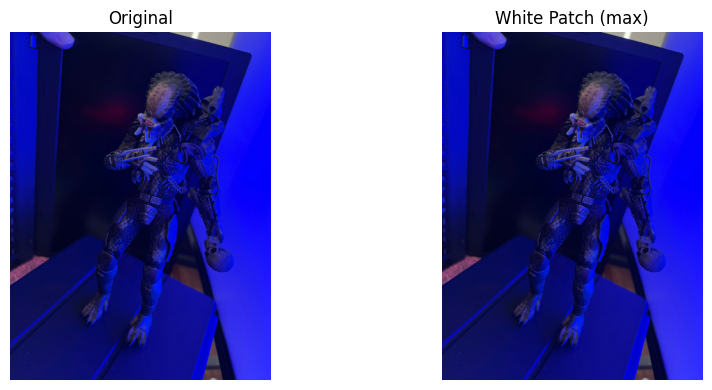

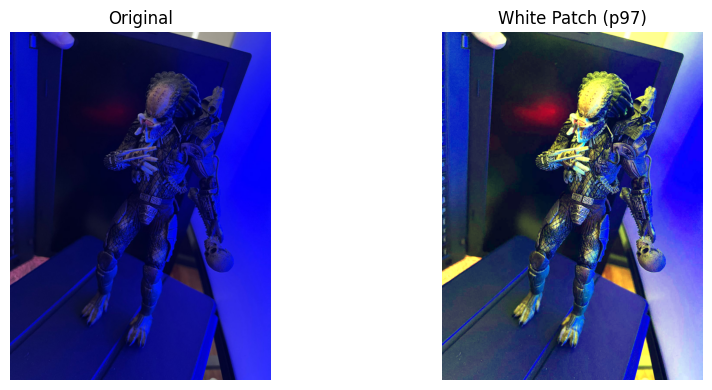

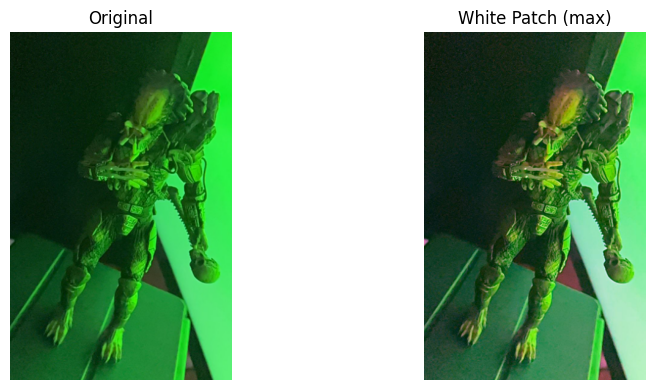

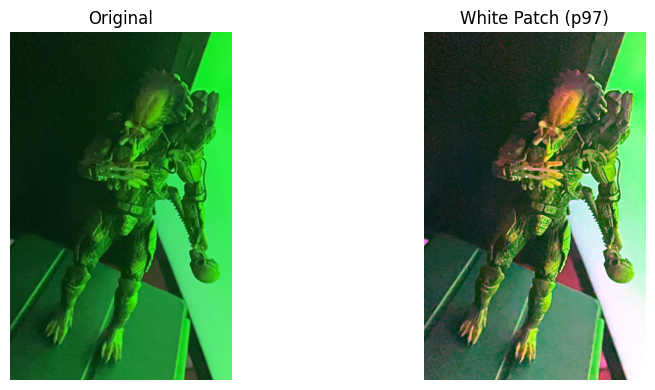

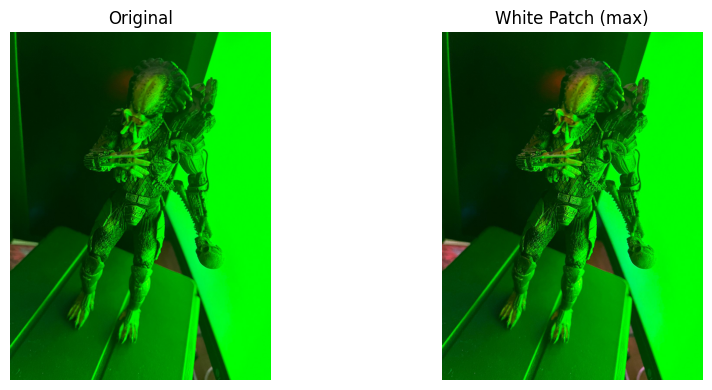

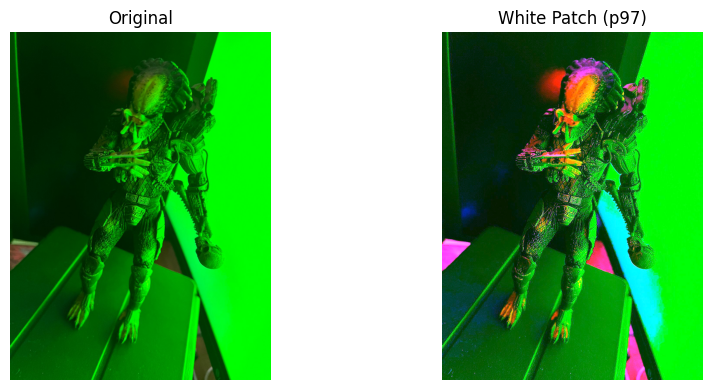

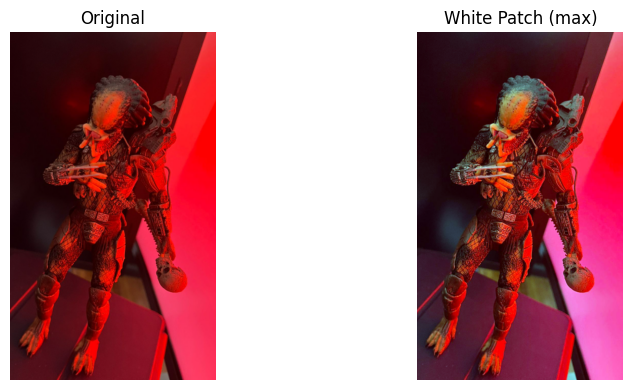

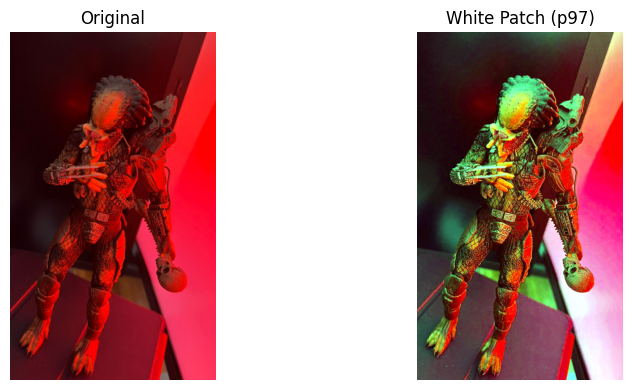

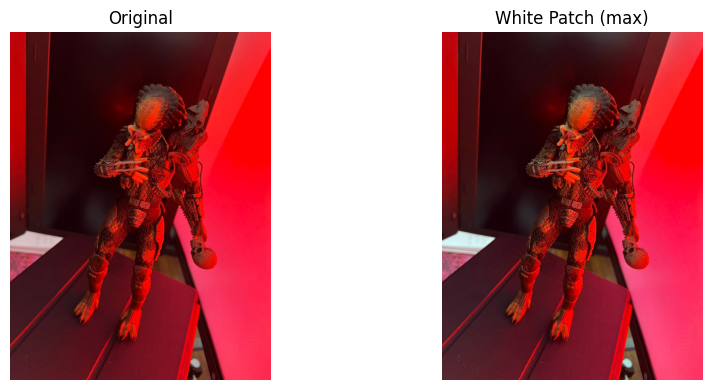

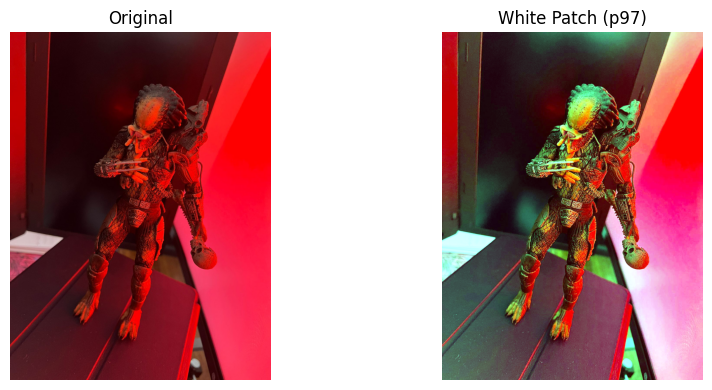

✅ Parte 1 lista (procesado + análisis).

RESUMEN DE MÉTRICAS
╒════════════════╤══════╤══════╤═══════════╤════════════╤═════════════╤══════════════════╤════════════════════════╕
│ file           │  w   │  h   │   sat_pct │   spec_pct │   noise_pct │   blockiness_idx │  suggested_percentile  │
╞════════════════╪══════╪══════╪═══════════╪════════════╪═════════════╪══════════════════╪════════════════════════╡
│ test_blue.png  │ 278  │ 100  │    0.000% │     0.000% │      0.011% │            4.386 │           99           │
├────────────────┼──────┼──────┼───────────┼────────────┼─────────────┼──────────────────┼────────────────────────┤
│ test_green.png │ 278  │ 100  │    0.011% │     0.000% │      0.050% │            4.431 │           99           │
├────────────────┼──────┼──────┼───────────┼────────────┼─────────────┼──────────────────┼────────────────────────┤
│ test_red.png   │ 276  │  99  │    0.000% │     0.000% │      0.007% │            4.375 │           99           │
├──────────

In [4]:
# Parte 1: Análisis de defectos, White Patch y comparación
 
robust_p = 97  # tu valor actual; podés reemplazar por la sugerencia por imagen si querés

imgs = sorted([p for p in DATA_WP.iterdir() 
               if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp",".tif",".tiff",".webp"}])
print(f"Imágenes encontradas: {len(imgs)}")

summary = []  # acumulamos métricas por imagen

for p in imgs:
    img = cv.imread(str(p), cv.IMREAD_COLOR)
    if img is None:
        print("⚠️ no legible:", p.name)
        continue

    # Análizamos desperfectos: píxeles “sospechosos” (especulares, ruidosos o saturados) antes de aplicar White Patch.
    metrics, masks = analyze_defects(img)
    save_masks_and_overlay(img, masks, OUT_ANALYSIS, p.stem)

    # Aplicamos White Patch para Max y perceptil robusto
    corr_max = white_patch(img, robust_percentile=None)
    corr_rob = white_patch(img, robust_percentile=robust_p)

    # Mostramos las imágenes
    show_side_by_side_bgr(img, corr_max, "Original", "White Patch (max)")
    show_side_by_side_bgr(img, corr_rob, "Original", f"White Patch (p{robust_p})")

    # Guardamos correcciones
    cv.imwrite(str(OUT_WP / f"{p.stem}_wp_max.png"), corr_max)
    cv.imwrite(str(OUT_WP / f"{p.stem}_wp_p{robust_p}.png"), corr_rob)

    # Registramos por imagen
    row = {"file": p.name, **metrics}
    summary.append(row)

print("✅ Parte 1 lista (procesado + análisis).")

# Mostramos resumen tabular
cols1 = ["file","w","h","sat_pct","spec_pct","noise_pct","blockiness_idx","suggested_percentile"]
colalign1 = ["left","center","center","right","right","right","right","center"]

print_table(summary, cols1, "RESUMEN DE MÉTRICAS", colalign=colalign1)

# Guardamos CSV
csv_path = OUT_ANALYSIS / "summary_metrics.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=cols1)
    writer.writeheader()
    for r in summary:
        writer.writerow({c: r.get(c, "") for c in cols1})
print(f"\n📄 CSV guardado en: {csv_path}")

In [5]:
# PASADA 1: robust fijo (damos consistencia para la comparación)
fixed_p = robust_p  # Adoptamos el mismo valor usado antes
summary_fixed = []

for p in imgs:
    img = cv.imread(str(p), cv.IMREAD_COLOR)
    if img is None:
        continue

    # Calculamos métricas de "desperfectos" (antes de corregir)
    metrics, masks = analyze_defects(img)
    save_masks_and_overlay(img, masks, OUT_ANALYSIS, p.stem)

    # Apicamos corrección White Patch con robust percentile fijo
    corr_fixed = white_patch(img, robust_percentile=fixed_p)
    cv.imwrite(str(OUT_WP / f"{p.stem}_wp_p{fixed_p}_fixed.png"), corr_fixed)

    row = {"file": p.name, **metrics, "run_type": "fixed", "used_percentile": fixed_p}
    summary_fixed.append(row)

print(f"✅ Pasada fija p={fixed_p} terminada.")

# PASADA 2: robust AUTO por imagen (usamos suggested_percentile)
summary_auto = []

for p in imgs:
    img = cv.imread(str(p), cv.IMREAD_COLOR)
    if img is None:
        continue

    metrics, _ = analyze_defects(img)  # ya guardamos máscaras en la pasada fija
    rp = int(metrics["suggested_percentile"])  # 95 / 97 / 99

    corr_auto = white_patch(img, robust_percentile=rp)
    cv.imwrite(str(OUT_WP / f"{p.stem}_wp_p{rp}_auto.png"), corr_auto)

    row = {"file": p.name, **metrics, "run_type": "auto", "used_percentile": rp}
    summary_auto.append(row)

print("✅ Pasada auto terminada.")

# Unificamos y guardamos CSV
summary_all = summary_fixed + summary_auto
cols = ["file","w","h","sat_pct","spec_pct","noise_pct","blockiness_idx",
        "suggested_percentile","run_type","used_percentile"]

csv_path = OUT_ANALYSIS / "summary_metrics_with_used_p.csv"
with open(csv_path, "w", encoding="utf-8") as f:
    f.write(",".join(cols) + "\n")
    for r in summary_all:
        f.write(",".join(str(r[c]) for c in cols) + "\n")

print(f"📄 CSV guardado: {csv_path}")

✅ Pasada fija p=97 terminada.
✅ Pasada auto terminada.
📄 CSV guardado: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/outputs/white_patch_analysis/summary_metrics_with_used_p.csv


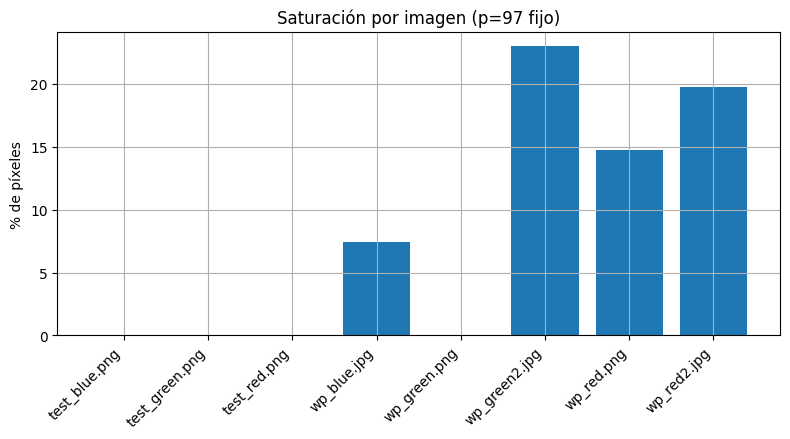

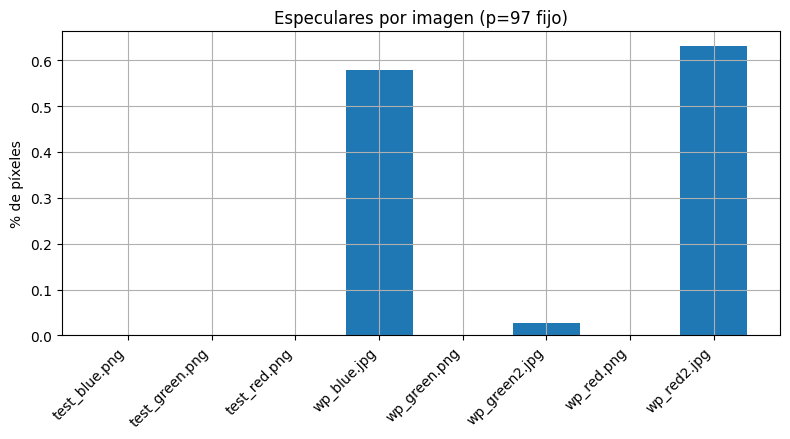

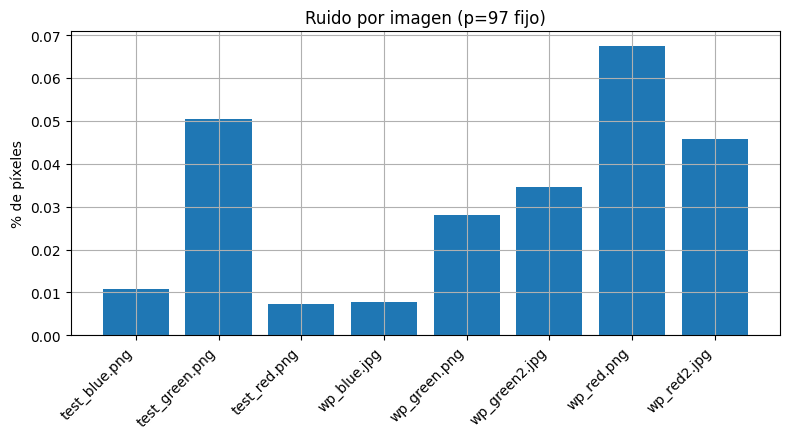

In [6]:
# Chart de barras comparativo de métricas (fijo) sat/spec/noise por archivo
rows = summary_fixed  # Podemos tomar summary_auto para comparar con ajuste del percentil dinámico (adaptativa)
files = [r["file"] for r in rows]
x = np.arange(len(files))

sat = np.array([r["sat_pct"] for r in rows])
spec = np.array([r["spec_pct"] for r in rows])
noise = np.array([r["noise_pct"] for r in rows])

def barplot_metric(x, files, values, title, ylabel="% de píxeles"):
    plt.figure(figsize=(max(8, len(files)*0.9), 4.5))
    plt.bar(x, values)
    plt.xticks(x, files, rotation=45, ha="right")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

barplot_metric(x, files, sat,  f"Saturación por imagen (p={fixed_p} fijo)")
barplot_metric(x, files, spec, f"Especulares por imagen (p={fixed_p} fijo)")
barplot_metric(x, files, noise, f"Ruido por imagen (p={fixed_p} fijo)")

In [7]:
# Resúmenes tabulares

cols2 = ["file","w","h","sat_pct","spec_pct","noise_pct","blockiness_idx",
         "suggested_percentile","run_type","used_percentile"]

colalign2 = ["left","center","center","right","right","right","right","center","center","center"]

print_table(summary_fixed, cols2, f"Resumen FIXED p={fixed_p}", colalign=colalign2)
print_table(summary_auto,  cols2, "Resumen AUTO (percentil sugerido)", colalign=colalign2)



Resumen FIXED p=97
╒════════════════╤══════╤══════╤═══════════╤════════════╤═════════════╤══════════════════╤════════════════════════╤════════════╤═══════════════════╕
│ file           │  w   │  h   │   sat_pct │   spec_pct │   noise_pct │   blockiness_idx │  suggested_percentile  │  run_type  │  used_percentile  │
╞════════════════╪══════╪══════╪═══════════╪════════════╪═════════════╪══════════════════╪════════════════════════╪════════════╪═══════════════════╡
│ test_blue.png  │ 278  │ 100  │    0.000% │     0.000% │      0.011% │            4.386 │           99           │   fixed    │        97         │
├────────────────┼──────┼──────┼───────────┼────────────┼─────────────┼──────────────────┼────────────────────────┼────────────┼───────────────────┤
│ test_green.png │ 278  │ 100  │    0.011% │     0.000% │      0.050% │            4.431 │           99           │   fixed    │        97         │
├────────────────┼──────┼──────┼───────────┼────────────┼─────────────┼───────────────

# Parte 1: Explicación y conclusiones

## 📊 1. Variables calculadas

| Variable | Significado |
|-----------|-------------|
| **file, w, h** | Nombre del archivo y sus dimensiones (ancho y alto). |
| **sat_pct** | Porcentaje de saturación: mide qué fracción de píxeles están saturados (en los extremos de la escala de intensidad, 0 o 255). Saturaciones altas suelen indicar pérdida de detalle o sobreexposición. |
| **spec_pct** | Porcentaje de brillos especulares (reflejos intensos). Indica exceso de luz en regiones puntuales. |
| **noise_pct** | Proporción de píxeles con ruido alto. Estimado mediante varianzas locales o filtros de mediana. |
| **blockiness_idx** | Índice de compresión o bloque (artefactos JPEG). Valores altos indican defectos visuales notables. |
| **suggested_percentile** | Percentil sugerido automáticamente según las métricas de calidad de imagen. |
| **run_type** | Indica si el cálculo se hizo con un percentil fijo o con ajuste automático. |
| **used_percentile** | Percentil finalmente aplicado en la ejecución correspondiente (probamos 95, 97, 99). |

---

## ⚙️ 2. Qué es el percentil robusto

El **percentil robusto** es una medida estadística que **descarta los valores extremos** (outliers) al definir el rango útil de intensidades de una imagen.

- En lugar de usar el valor máximo absoluto (100%), se usa un percentil alto —generalmente 95 a 99—.
- Esto evita que unos pocos píxeles anómalos (ruido, reflejos o saturaciones) distorsionen la normalización global en White patch.

**👉 En resumen:**  
> El percentil robusto ajusta el rango dinámico de manera adaptativa, maximizando el contraste real sin amplificar el ruido ni los valores fuera de rango.

---

## 📈 3. Por qué el percentil robusto es el mejor criterio

1. **Estabilidad frente a ruido o artefactos**
   - Cuando las imágenes presentan alto `noise_pct` o `blockiness_idx`, los valores máximos se ven contaminados.
   - Usar el percentil robusto ignora esas colas y mantiene la estructura principal de la imagen.

2. **Adaptación al tipo de imagen**
   - Las imágenes sintéticas (`test_*.png`) son limpias y admiten percentil 99.
   - Las fotos reales (`wp_*.jpg`) muestran saturaciones y ruido, por lo que el percentil 95 evita sobreajustes.

3. **Consistencia entre métricas**
   - Si `sat_pct`, `spec_pct` y `noise_pct` son bajos → se mantiene 99%.
   - Si alguna sube → se baja a 95% para ganar robustez.
   - El algoritmo adapta automáticamente el umbral según las condiciones de cada imagen.

4. **Concordancia entre “suggested” y “auto”**
   - En el modo `auto`, los percentiles calculados coinciden con los sugeridos.
   - Esto confirma que la heurística de selección está bien calibrada y es estable.

---

## 🎯 4. Conclusiones

> El percentil robusto optimiza la normalización de luminosidad porque equilibra dos objetivos:
> - Mantener la información relevante (contraste natural).
> - Suprimir valores atípicos causados por ruido, reflejos o compresión.

Por ello:
- En imágenes sintéticas o limpias → `99%` es ideal.  
- En fotos reales con más ruido → `95%` evita la amplificación de ruido.  
- Aplicar el percentil robusto mejora la **consistencia perceptual**, la **reproducibilidad** y la **calidad visual final** del procesamiento.

# Parte 2: 
- 2.1 Escala de grises de dos imágenes y visualización
- 2.2 Graficar histogramas de intensidad de ambas imágenes, eligiendo el número de bins apropiado. Explicar lo observado y
    justificar la utilidad o no de tomar como feature el histograma de intensidad para etrenar un modelo.


Ruta de trabajo: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/notebooks
Directorio data: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/data


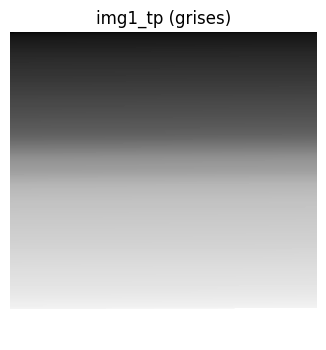

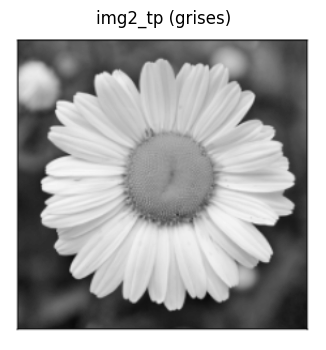

In [8]:
# Parte 2: Lectura de las 2 imágenes en escala de grises y visualización

BASE = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
DATA = BASE.parent / "data"   # sube un nivel y entra en /data

IMG1 = DATA / "img1_tp.png"
IMG2 = DATA / "img2_tp.png"

print("Ruta de trabajo:", BASE)
print("Directorio data:", DATA)

img1 = cv.imread(str(IMG1), cv.IMREAD_GRAYSCALE)
img2 = cv.imread(str(IMG2), cv.IMREAD_GRAYSCALE)

assert img1 is not None and img2 is not None, "❌ No se pudieron leer img1_tp.png o img2_tp.png"

def show_gray(img, title):
    plt.figure(figsize=(5,4))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_gray(img1, "img1_tp (grises)")
show_gray(img2, "img2_tp (grises)")

h1 sum: 0.999999999999988 h2 sum: 0.999999999999988
h1==h2 exacto?: True
h1≈h2 (allclose)?: True
hist 1 primeros 10 bins: [0.00000000e+00 2.41966705e-05 2.41966705e-05 0.00000000e+00
 0.00000000e+00 3.25445219e-03 1.57278358e-04 3.99245064e-04
 7.37998451e-04 1.56068525e-03]
hist 2 primeros 10 bins: [0.00000000e+00 2.41966705e-05 2.41966705e-05 0.00000000e+00
 0.00000000e+00 3.25445219e-03 1.57278358e-04 3.99245064e-04
 7.37998451e-04 1.56068525e-03]


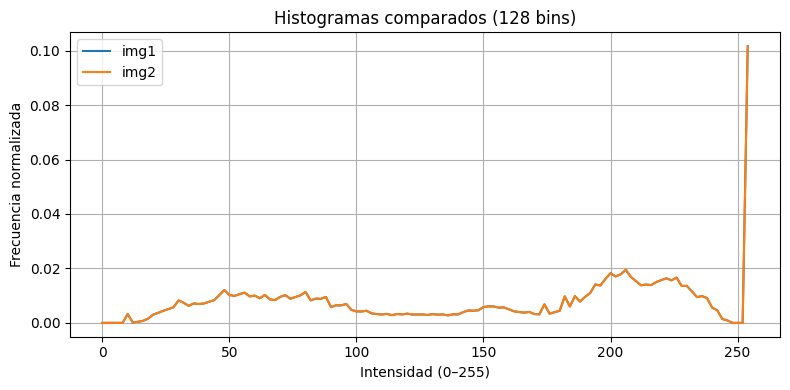

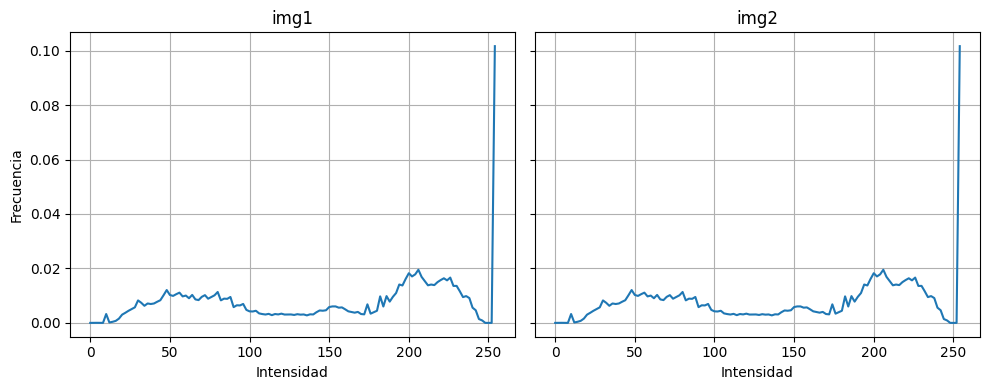

In [9]:
# Histogramas normalizados

def compute_hist(img_gray, bins=64):
    hist, edges = np.histogram(img_gray.ravel(), bins=bins, range=(0,256))
    hist = hist / (hist.sum() + 1e-9)  # normalización a [0,1]
    return hist, edges

bins = 128  # número de bins para el histograma
h1, e1 = compute_hist(img1, bins)
h2, e2 = compute_hist(img2, bins)

print("h1 sum:", h1.sum(), "h2 sum:", h2.sum())
print("h1==h2 exacto?:", np.array_equal(h1, h2))
print("h1≈h2 (allclose)?:", np.allclose(h1, h2, atol=1e-9))

print("hist 1 primeros 10 bins:", h1[:10])
print("hist 2 primeros 10 bins:", h2[:10])

plt.figure(figsize=(8,4))
plt.plot(e1[:-1], h1, label="img1")
plt.plot(e2[:-1], h2, label="img2")
plt.title(f"Histogramas comparados ({bins} bins)")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia normalizada")
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
ax[0].plot(e1[:-1], h1); ax[0].set_title("img1"); ax[0].set_xlabel("Intensidad"); ax[0].set_ylabel("Frecuencia")
ax[1].plot(e2[:-1], h2); ax[1].set_title("img2"); ax[1].set_xlabel("Intensidad")
plt.tight_layout(); plt.show()

In [10]:
# Métricas de similitud entre histogramas: Chi-cuadrado, Bhattacharyya, Correlación

def chi_square(h1, h2, eps=1e-9):
    return 0.5 * np.sum((h1 - h2)**2 / (h1 + h2 + eps))

def bhattacharyya(h1, h2, eps=1e-9):
    bc = np.sum(np.sqrt(h1 * h2))
    return -np.log(bc + eps)

chi2  = chi_square(h1, h2)
bhat  = bhattacharyya(h1, h2)
corr  = np.corrcoef(h1, h2)[0,1]

metrics_table = [
    ["Chi-cuadrado", f"{chi2:.4f}"],
    ["Bhattacharyya", f"{bhat:.4f}"],
    ["Correlación", f"{corr:.4f}"],
]

print(tabulate(metrics_table, headers=["Métrica","Valor"], tablefmt="fancy_grid", stralign="center"))

╒═══════════════╤═════════╕
│    Métrica    │   Valor │
╞═══════════════╪═════════╡
│ Chi-cuadrado  │       0 │
├───────────────┼─────────┤
│ Bhattacharyya │      -0 │
├───────────────┼─────────┤
│  Correlación  │       1 │
╘═══════════════╧═════════╛


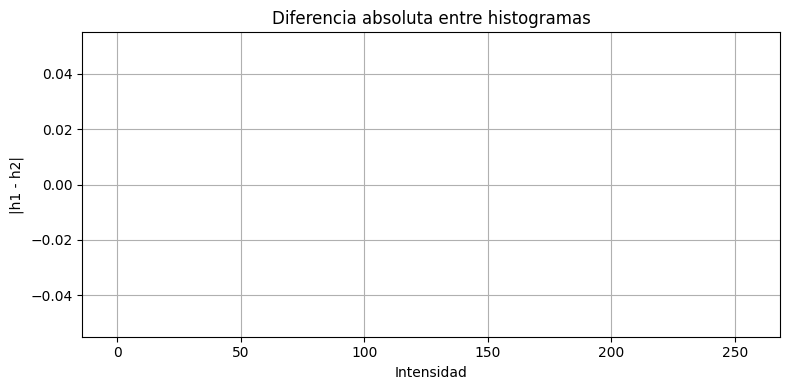

In [11]:
# Comparacion visual directa

plt.figure(figsize=(8,4))
plt.bar(e1[:-1], np.abs(h1 - h2), width=3, color='gray')
plt.title("Diferencia absoluta entre histogramas")
plt.xlabel("Intensidad")
plt.ylabel("|h1 - h2|")
plt.tight_layout()
plt.show()

In [12]:
print("IMG1:", IMG1)
print("IMG2:", IMG2)
print("Shape img1:", None if img1 is None else img1.shape)
print("Shape img2:", None if img2 is None else img2.shape)
print("¿Son el mismo archivo? ", IMG1.resolve() == IMG2.resolve())
print("¿Tienen el mismo tamaño?", img1.shape == img2.shape)

import hashlib
def md5_of_image(img):
    return hashlib.md5(img.tobytes()).hexdigest()[:12]

print("MD5 img1:", md5_of_image(img1))
print("MD5 img2:", md5_of_image(img2))

IMG1: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/data/img1_tp.png
IMG2: /home/ossiemunoz/projects/Vision_computadora_I/Material_TPs/TP1/data/img2_tp.png
Shape img1: (288, 287)
Shape img2: (288, 287)
¿Son el mismo archivo?  False
¿Tienen el mismo tamaño? True
MD5 img1: 8777f435a492
MD5 img2: a0a8431b8eb8


In [13]:
print("img1 range:", img1.min(), "→", img1.max())
print("img2 range:", img2.min(), "→", img2.max())

img1 range: 2 → 255
img2 range: 2 → 255
